# Final Project for DTSA-5510

Kevin Juandi <br> 2023-11-26<br> https://github.com/Chiuchiyin/Pneumonia-Classification-with-Computer-Vision

## Introduction and Problem Description

Welcome to my final project for DTSA-5510! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed in the next section. If you want to run the code, some parts of the code might take very long time to run. At the time of this writing, I have not attempted to train a model but I expect it to take a couple of hours. Please be patient with it. Thank you for reviewing my project!

For the previous module **DTSA-5509**, I worked on [Heartbeat ECG Classification](https://github.com/Chiuchiyin/Heartbeat-ECG-Classification). I would like to expand my repetoire in health analytics and have decided to work on Pneumonia Classification.

The data I will use can be found at Mendeley Data[<sup>[1]</sup>](https://data.mendeley.com/datasets/rscbjbr9sj/3). The data contain images of both chest X-Rays and Optical Coherence Tomography. The original paper uses deep learning algorithm which I would not attempt to replicate due to computational requirements. I will just use the chest X-rays in this project. I have included the data in the Github Repository so if you decided to download the data so you don't have to download the entire dataset and extract them yourself.

The chest X-ray data in "train" contains 1.18 GB of data - consisting of 1349 "normal" chest X-rays, 1345 X-rays with viral pneumonia, and 2538 X-rays with bacterial pneumonia. The "test" data contains 105 MB of data - there are 234 "normal" chest X-rays, 148 with viral pneumonia, and 242 with bacterial pneumonia.

## Loading dependancies

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import os
import math
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import time
import itertools
import random
from collections import Counter
%matplotlib inline

## Helper functions
We would use these functions to reduce clutter

In [30]:
def readXRay(path, pixDesired = 1000, n_imgs = "use all"):
    """
        input: string path, of form ("./data/ os.listdir(parent directory)
        input: int pixDesired, the number of pixels pixDesired X pixDesired in which to read the data. 
               If None, no transformation is performed.
        input: int n_imgs, number of images to be read from file. 
            Preset is string "use all", which uses all the images in the provided path.
        output: np.ndarray data
    """
    
    # Initialize data
    firstImagePath = path + os.listdir(path)[0]
    firstPic = cv.imread(firstImagePath, 0)
    if pixDesired != None:
        data = cv.resize(firstPic, (pixDesired, pixDesired))
        data = data.reshape(1, pixDesired ** 2)# If performance allows, increase resize!
    else:
        data = data.reshape(1, firstPic.shape[0] * firstPic.shape[1])
    
    # Populate data
    
    if n_imgs == "use all":
        for img in os.listdir(path)[1:]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired))
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
            
    else:
        for img in os.listdir(path)[1:n_imgs]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired)) # If performance allows, increase resize!
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
        
    return(data)

In [32]:
    
# Finalize predictions from NMF.fit_transform()
def finalizePredictions(W):
    """
        input: numpy.ndarray W (e.g. output of NMF.fit_transform())
        output: numpy.ndarray predictions
    """
    predictions = np.zeros(shape = (W.shape[0]))
    n_rows = W.shape[0]
    n_cols = W.shape[1]
    
    for i in range(n_rows):
        current_best = (None, 0) # current_best is of form (column number, highest weight)
        for j in range(n_cols):
            if W[i, j] > current_best[1]:
                current_best = (j, W[i, j])
        
        if current_best[0] == None:
            print("Something bad happened")
            
        predictions[i] = current_best[0]
    
    return(predictions.astype(int))

# Create label reconstructor using a best subset algorithm
def reconstructLabels(pred, trueLabs):
    """
        input: np.ndarray pred of shape (n_images, )
        input np.ndarray trueLabs of shape (n_images, )
        output: np.ndarray yhat of shape (n_images, )
    """
    n = pred.shape[0]
    categories = list(np.unique(trueLabs))
    permutations = list(itertools.permutations(categories))
    
    currentBest = (None, float("inf"))
    
    for subset in permutations:
        n_misclassified = 0
        for i in range(n):
            if subset[int(pred[i])] != trueLabs[i]:
                n_misclassified = n_misclassified + 1
        if n_misclassified < currentBest[1]:
            currentBest = (subset, n_misclassified)
    
    return(currentBest)



In [63]:
def majorityRule3(predictionMatrix):
    """
        input: np.ndarray predictionMatrix of shape (n_models, n_images)
        output: np.ndarray baggedPred of shape (n_images, )
    """
    # The algorithm we will use is to pick the mode if possible, then break ties randomly.    
    baggedPred = np.zeros(predictionMatrix.shape[1]).astype(int)
    #Populate baggedPred
    for j in range(predictionMatrix.shape[1]):
        counts = {
            0: 0,
            1: 0,
            2: 0
        }
        #Populate counts
        for i in range(predictionMatrix.shape[0]):
            this_prediction = predictionMatrix[i, j]
            counts.update({this_prediction : counts[this_prediction] + 1})
        #Determine the winner
        if counts[0] > counts[1] and counts[0] > counts[2]:
            baggedPred[j] = 0
        elif counts[1] > counts[0] and counts[1] > counts[2]:
            baggedPred[j] = 1
        elif counts[2] > counts[0] and counts[2] > counts[1]:
            baggedPred[j] = 2
        else: # Break ties randomly
            tieBreaker = random.random()
            # There are three rows, so there can be a three way tie. We will flip a coin to pick the winner.
            if counts[0] == counts[1] and counts[0] > counts[2]:
                assert counts[1] > counts[2]
                if tieBreaker < .5:
                    baggedPred[j] = 0
                else:
                    baggedPred[j] = 1
            elif counts[0] == counts[2] and counts[0] > counts[1]:
                assert counts[2] > counts[1]
                if tieBreaker < .5:
                    baggedPred[j] = 0
                else:
                    baggedPred[j] = 2
            elif counts[1] == counts[2] and counts[1] > counts[0]:
                assert counts[2] > counts[0]
                if tieBreaker < .5:
                    baggedPred[j] = 1
                else:
                    baggedPred[j] = 2
            else:
                # 3 Way Tie
                assert counts[1] == counts[2] and counts[2] == counts[0]
                if tieBreaker < 1/3:
                    baggedPred[j] = 0
                elif tieBreaker < 2/3:
                    baggedPred[j] = 1
                else:
                    baggedPred[j] = 2

    return(baggedPred)

## Load the Data and Perform EDA
### Loading the Data

In [3]:
%cd ".\chest_xray"

os.listdir()

C:\Users\silve\OneDrive\Dokumente\Github\DTSA5510-Unsupervised-Learning-Final-Project\chest_xray


['reducedData.csv', 'test', 'train']

In [4]:
# Example XRay. Citation https://www.geeksforgeeks.org/python-opencv-cv2-imshow-method/
# Set file path
startTime = time.time()
repopath = "./train/" + "NORMAL/"
filepath = repopath + os.listdir(repopath)[0]

#Read in test image
testpic = cv.imread(filepath, 0)
#testpic = cv.resize(testpic, (256, 256))

endTime = time.time()

##Show test image
testWindow = "Example XRAY. This is a healthy lung."
cv.imshow(testWindow, testpic)
cv.waitKey(0)  #Wait for the user to press a key before closing the window
cv.destroyAllWindows() 

print(testpic.shape)
print(endTime - startTime)

(2476, 2572)
0.09709739685058594


From running the code above, we could see that the images are particularly large but are they all in the same size? Let us check the size of the next image.

In [8]:
filepath1 = repopath + os.listdir(repopath)[1]
testpic1 = cv.imread(filepath1, 0)
print(testpic1.shape)

(1751, 1982)


This confirms that not all of the images are the same dimension. We would therefore need to resize the images to the same size. to do this, we use the pixDesired option to standardize the images to a square of desired size. For computational reason, we set the auto selection of 1000 pixels per image.

In [5]:
# Set up paths of repositories to read data from
paths = ["./train/NORMAL/", "./train/VIRAL/", "./train/BACTERIAL/", 
         "./test/NORMAL/", "./test/VIRAL/", "./test/BACTERIAL/"]

In [16]:
#Initialize data
firststartTime = time.time()
data = readXRay(path = paths[0], pixDesired = 100, n_imgs = "use all")
firstendTime = time.time()
print(firstendTime - firststartTime) #How long did this repo take to convert?
print(data.shape) #How many files in this repo?

#Populate data with the other repositories
for path in paths[1:]:
    startTime = time.time()
    this_data = readXRay(path = path, pixDesired = 100, n_imgs = "use all")
    endTime = time.time()

    print(endTime - startTime) #How long did this repo take to convert?
    print(this_data.shape) #How many files in this repo?
    data = np.append(data, this_data, axis = 0)

print(endTime - firststartTime)
print(data.shape)

20.751718282699585
(1349, 10000)
7.880717754364014
(1345, 10000)
17.327439308166504
(2538, 10000)
2.386894702911377
(234, 10000)
0.5994760990142822
(148, 10000)
0.6994566917419434
(242, 10000)
49.6903555393219
(5856, 10000)


In [17]:
# Records 3 class labels in np.ndarray
Normal1 = np.asarray(["NORMAL" for i in range(1349)])
Viral1 = np.asarray(["VIRAL" for i in range(1345)])
Bacterial1 = np.asarray(["BACTERIAL" for i in range(2538)])
Normal2 = np.asarray(["NORMAL" for i in range(234)])
Viral2 = np.asarray(["VIRAL" for i in range(148)])
Bacterial2 = np.asarray(["BACTERIAL" for i in range(242)])
labs = np.append(Normal1, Viral1, axis = 0)
labs = np.append(labs, Bacterial1, axis = 0)
labs = np.append(labs, Normal2, axis = 0)
labs = np.append(labs, Viral2, axis = 0)
labs = np.append(labs, Bacterial2, axis = 0)

assert labs.shape[0] == data.shape[0]

print(labs.shape)

(5856,)


In [18]:
# Records 2 class labels in np.ndarray
Infected1 = np.asarray(["INFECTED" for i in range(1345 + 2538)])
Infected2 = np.asarray(["INFECTED" for i in range(148 + 242)])

labs2 = np.append(Normal1, Infected1, axis = 0)
labs2 = np.append(labs2, Normal2, axis = 0)
labs2 = np.append(labs2, Infected2, axis = 0)

assert labs2.shape[0] == data.shape[0]

print(labs2.shape)

(5856,)


Using pixDesired = 100 resulted in a total data reading time of roughly 46 seconds. Using pixDesired = 500 resulted in a total time of 320 seconds. An interesting extension to the project would be measuring accuracy vs. pixDesired over perhaps an order of magnitude of pixDesired. With the 500 pixDesired, we would need an extra 10 GB of RAM to run the NMF, which is way too much. I'll stick with pixDesired = 100 for now and probably try larger value later. Note that this will severly damage accuracy.

### PCA
We would then perform PCA to reduce the data to more manageable size.

In [19]:
#Perform PCA. We will use a minimum explained variance of 0.98 so as to prevent inhibiting our models from successfully categorizing the X-Rays
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")

startTime = time.time()
reducedData = pca.fit_transform(data)
endTime = time.time()

# Print result summary
print(endTime - startTime)
print(reducedData.shape)

182.06255674362183
(5856, 1533)


In [20]:
#Write the resulting data to a csv so that we don't need to process it again in future analysis
startTime = time.time()
np.savetxt("reducedData.csv", reducedData, delimiter=",")
endTime = time.time()
print(endTime - startTime)

5.357702732086182


### EDA
We would now do some basic EDA on the data.The features of the individual data are individual pixels read in greyscale. The values thus range from 0 to 255.

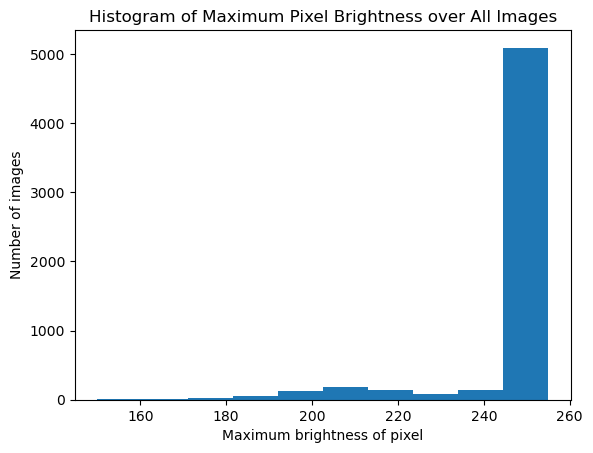

In [21]:
# Make histogram of max values
maxes = list(np.max(data, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Pixel Brightness over All Images")
plt.show()

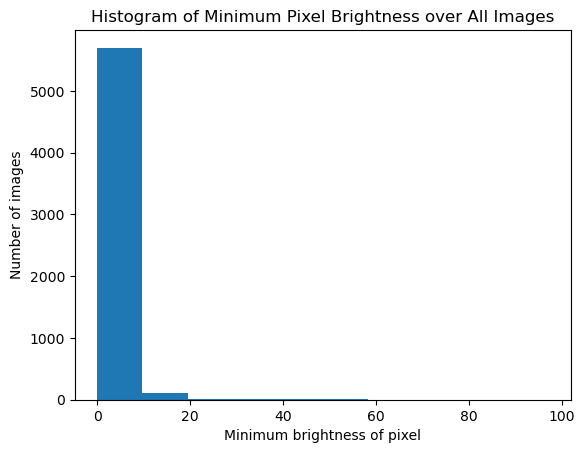

In [22]:
mins = np.min(data, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Pixel Brightness over All Images")
plt.show()

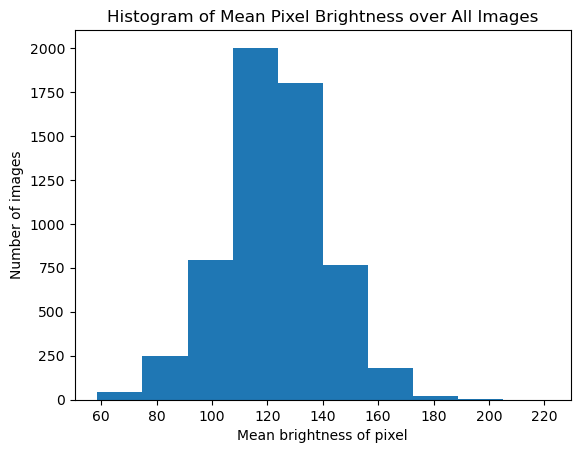

In [23]:
means = np.mean(data, axis = 1)
plt.hist(means)
plt.xlabel("Mean brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Pixel Brightness over All Images")
plt.show()

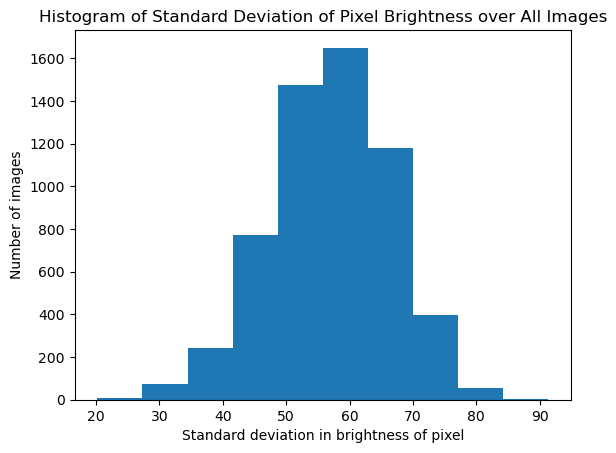

In [24]:
stds = np.std(data, axis = 1)
plt.hist(stds)
plt.xlabel("Standard deviation in brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Standard Deviation of Pixel Brightness over All Images")
plt.show()

After performing PCA on the image data, the new features are coordinates in the new dimensions where we use the eigenvectors of the principal components as basis vectors. As such they lose human comprehensibility. I will print out the histograms of min, max, mean, and standard deviation, but do note they don't have easy translations in the new space.

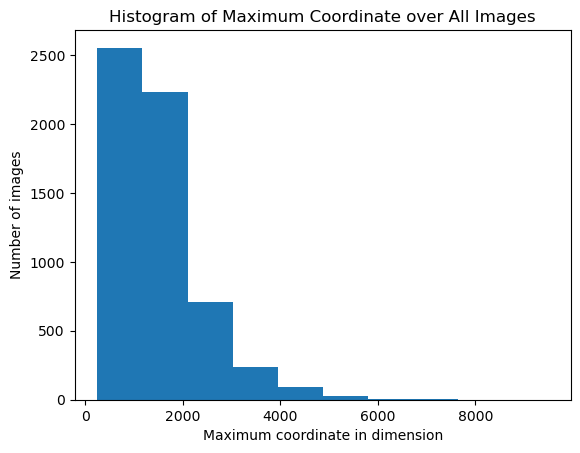

In [25]:
# Make histogram of max values
maxes = list(np.max(reducedData, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Coordinate over All Images")
plt.show()

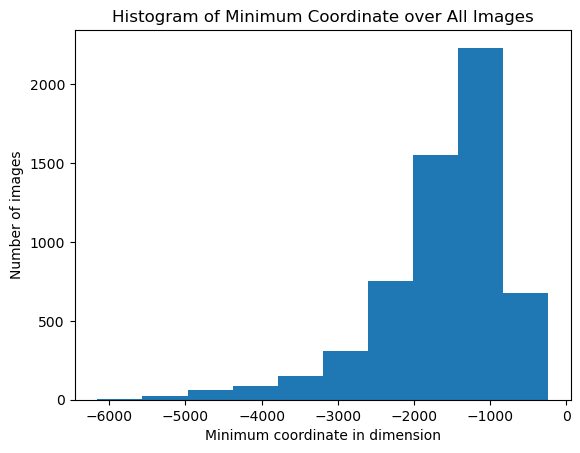

In [26]:
# Make histogram of min values
mins = np.min(reducedData, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Coordinate over All Images")
plt.show()

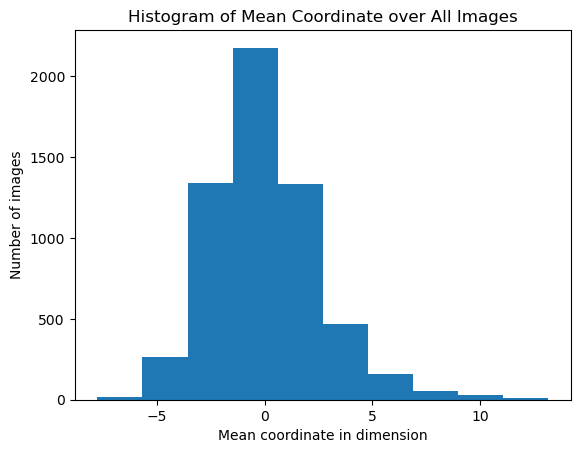

In [27]:
# Make histogram of min values
means = np.mean(reducedData, axis = 1)
plt.hist(means)
plt.xlabel("Mean coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Coordinate over All Images")
plt.show()

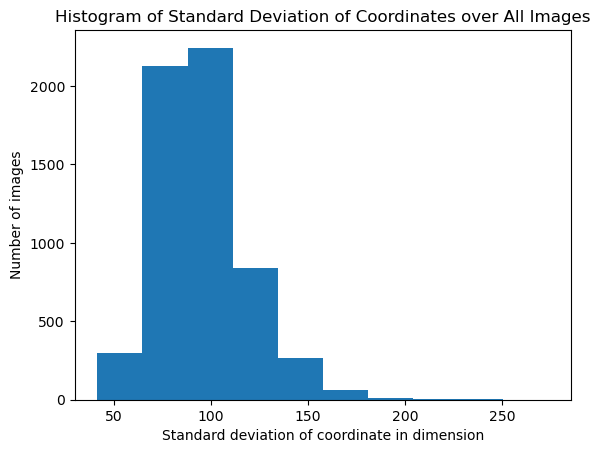

In [28]:
# Make histogram of standard deviations
# Make histogram of min values
stds = np.std(reducedData, axis = 1)
plt.hist(stds)
plt.xlabel("Standard deviation of coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Standard Deviation of Coordinates over All Images")
plt.show()

## Building Unsupervised Learning Models

### NMF:
NMF is a great first attack at categorizing the data, because there are no missing values in the rectangular data matrix. Unfortunately the reducedData has negative values as can be seen in the EDA, so we must use NMF on the original dataset. This model will probably take the longest to train because we have the most features. It also has the best chance of being accurate, because we aren't limiting the explained variance to 0.98. I'll do an SVD on the reducedData afterwards and compare against the NMF. I will use n_components = 3 for all my unsupervised models, representing Normal, Viral, and Bacterial chest X-Rays. I will do a couple hyperparameter choices, and compare models by classification accuracy / recall / precision.

#### L2 Loss: 3 categories

In [33]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_1 = NMF(n_components = 3, beta_loss = "frobenius", init = 'nndsvd', solver = "cd", max_iter = 1000)
startTime = time.time()
W_1 = nmf_model_1.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


133.1662745475769


The L2 NMF with 3 categories had accuracy: 0.415129781420765
The L2 NMF with 3 categories had weighted average precision: 0.4667463436674939
The L2 NMF with 3 categories had weighted average recall: 0.415129781420765


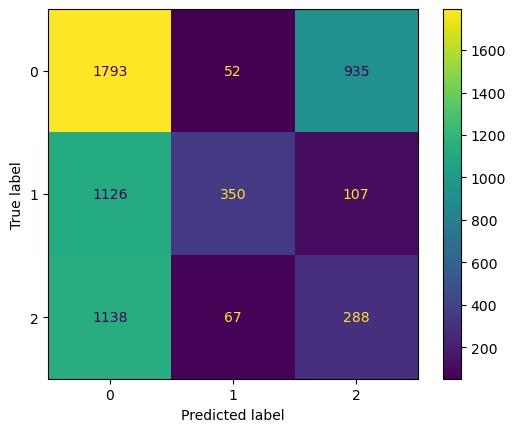

In [37]:
# Convert predictions into a form that sklearn will accept
yhat1 = finalizePredictions(W_1)
categoryNames = reconstructLabels(yhat1, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat1))
cm.plot()

# Compute accuracy, precision, and recall
print("The L2 NMF with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat1))
print("The L2 NMF with 3 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat1, average = "weighted"))
print("The L2 NMF with 3 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat1, average = "weighted"))

#### L2 Loss: 2 categories

In [38]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_2 = NMF(n_components = 2, beta_loss = "frobenius", init = 'nndsvd', solver = "cd", max_iter = 1000)
startTime = time.time()
W_2 = nmf_model_2.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


114.45938086509705


The L2 NMF with 2 categories had accuracy: 0.7170423497267759
The L2 NMF with 2 categories had weighted average precision: 0.6214155927334378
The L2 NMF with 2 categories had weighted average recall: 0.7170423497267759


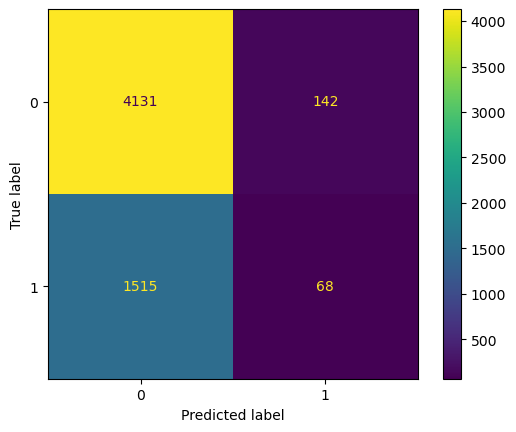

In [39]:
# Convert predictions into a form that sklearn will accept
yhat2 = finalizePredictions(W_2)
categoryNames = reconstructLabels(yhat2, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat2))
cm.plot()

print("The L2 NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat2))
print("The L2 NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat2, average = "weighted"))
print("The L2 NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat2, average = "weighted"))

#### KL Loss: 3 categories

In [40]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_3 = NMF(n_components = 3, beta_loss = "kullback-leibler", init = 'nndsvdar', solver = "mu", max_iter = 100)
startTime = time.time()
W_3 = nmf_model_3.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


127.78624320030212


The KL NMF with 3 categories had accuracy: 0.4593579234972678
The KL NMF with 3 categories had weighted average precision: 0.49287199168385987
The KL NMF with 3 categories had weighted average recall: 0.4593579234972678


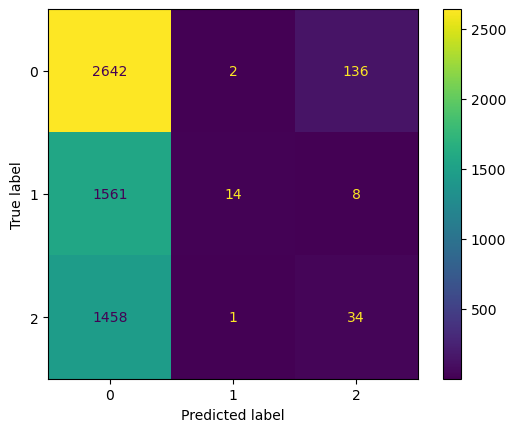

In [41]:
# Convert predictions into a form that sklearn will accept
yhat3 = finalizePredictions(W_3)
categoryNames = reconstructLabels(yhat3, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat3))
cm.plot()

# Compute accuracy, precision, and recall
print("The KL NMF with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat3))
print("The KL NMF with 3 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat3, average = "weighted"))
print("The KL NMF with 3 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat3, average = "weighted"))

#### KL Loss: 2 Categories

In [42]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_4 = NMF(n_components = 2, beta_loss = "kullback-leibler", init = 'nndsvdar', solver = "mu", max_iter = 100)
startTime = time.time()
W_4 = nmf_model_4.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


121.07178401947021


The KL NMF with 2 categories had accuracy: 0.7218237704918032
The KL NMF with 2 categories had weighted average precision: 0.5931068078865209
The KL NMF with 2 categories had weighted average recall: 0.7218237704918032


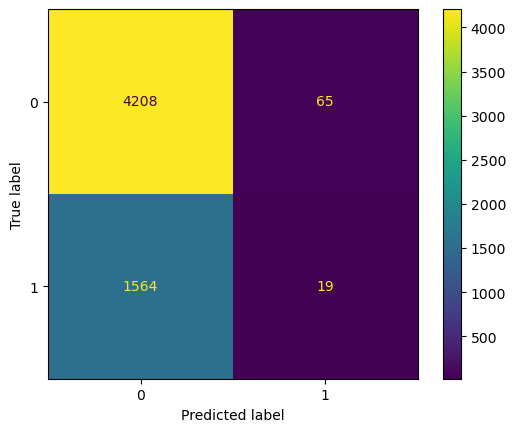

In [43]:
# Convert predictions into a form that sklearn will accept
yhat4 = finalizePredictions(W_4)
categoryNames = reconstructLabels(yhat4, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat4))
cm.plot()

# Compute accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat4))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat4, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat4, average = "weighted"))

These models performs poorly as expected. Hopefully that isn't an indication of things to come. I had to limit the number of iterations the KL-solver to improve execution time so that we aren't waiting forever for convergance, but as a downside the models suffer. The unsupervised algorithm doesn't know that the three categories have different prevalence in the data, so we would expect an accuracy of 33% as baseline. At least the models detected some disease! The KL model better has accuracy and recall, but the L2-Loss outperformed the KL-Loss surprisingly on precision.

One consideration is that the NMF is detecting stronger groupings than Normal / Virus / Bacteria. It may be detecting relative lung sizes (child / teen / adult), bone configurations, etc. Regardless, the NMF models are marginally useful at detecting pneumonia.

### K-Means:
K-means is a great algorithm that is easily human-comprehensible. The idea is to place some number of clusters in the feature space, and iterate their position until they are as close to as many points as possible. We will specify there to be 3 centroids, for the same reason we factored the full data into $(n_{images}, 3)\times (3, n_{pixels})$; we want the algorithm to realize that there are normal x-rays, bacterial infected x-rays, and viral infected x-rays. We will likely run into the same problem as in NMF, where we end up identifying trends other than pneumonia status. I will try using the two different algorithms in sklearn: "lloyd" and "elkan" and compare results.

#### Lloyd: 3 Categories

In [44]:
# Initialize Lloyd K-Means, and build predictions.
lloyd = KMeans(n_clusters = 3, random_state = 42, max_iter = 100, algorithm = "full")
startTime = time.time()
lloydModel = lloyd.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


3.007067918777466


The KL NMF with 2 categories had accuracy: 0.41171448087431695
The KL NMF with 2 categories had weighted average precision: 0.41364943884947114
The KL NMF with 2 categories had weighted average recall: 0.41171448087431695


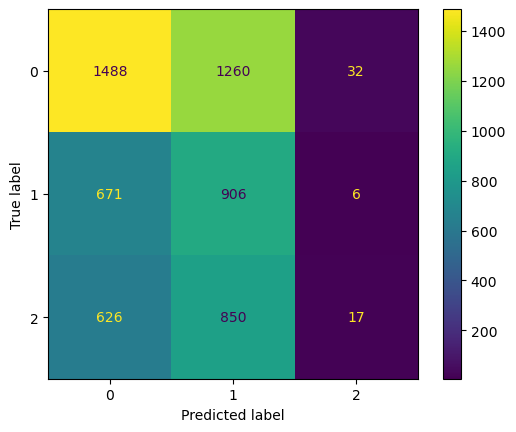

In [45]:
# Convert predictions into a form that sklearn will accept
yhat5 = finalizePredictions(lloydModel)
categoryNames = reconstructLabels(yhat5, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat5))
cm.plot()

# Compute accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat5))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat5, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat5, average = "weighted"))

#### Lloyd: 2 Categories

In [46]:
# Initialize Lloyd K-Means, and build predictions.
lloyd2 = KMeans(n_clusters = 2, random_state = 42, max_iter = 100, algorithm = "full")
startTime = time.time()
lloydModel2 = lloyd2.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


1.725590705871582


The KL NMF with 2 categories had accuracy: 0.5280054644808743
The KL NMF with 2 categories had weighted average precision: 0.6256130931833802
The KL NMF with 2 categories had weighted average recall: 0.5280054644808743


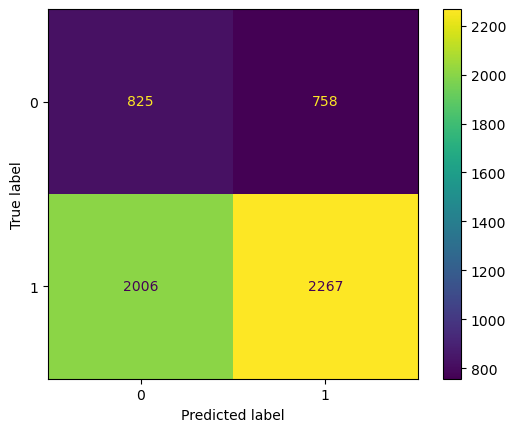

In [47]:
# Convert predictions into a form that sklearn will accept
yhat6 = finalizePredictions(lloydModel2)
categoryNames = reconstructLabels(yhat6, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat6))
cm.plot()

# Compute accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat6))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat6, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat6, average = "weighted"))

#### Elkan: 3 Categories

In [48]:
# Initialize Elkan K-Means, and build predictions.
elkan = KMeans(n_clusters = 3, random_state = 42, max_iter = 1000, algorithm = "elkan")
startTime = time.time()
elkanModel = elkan.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

1.5967929363250732


The KL NMF with 2 categories had accuracy: 0.41171448087431695
The KL NMF with 2 categories had weighted average precision: 0.41364943884947114
The KL NMF with 2 categories had weighted average recall: 0.41171448087431695


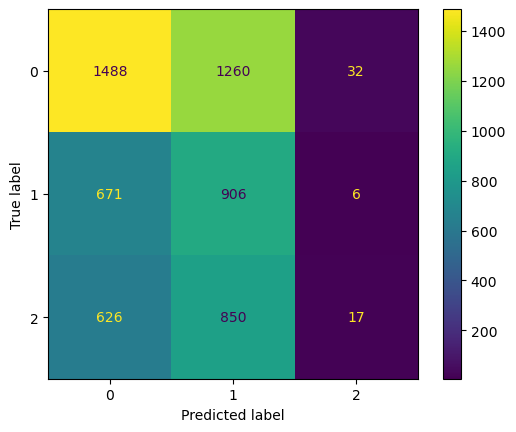

In [49]:
# Convert predictions into a form that sklearn will accept
yhat7 = finalizePredictions(elkanModel)
categoryNames = reconstructLabels(yhat7, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat7))
cm.plot()

# Compute accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat7))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat7, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat7, average = "weighted"))

#### Elkan: 2 Categories

In [50]:
# Initialize Elkan K-Means, and build predictions.
elkan2 = KMeans(n_clusters = 2, random_state = 42, max_iter = 1000, algorithm = "elkan")
startTime = time.time()
elkanModel2 = elkan2.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

0.8407409191131592


The KL NMF with 2 categories had accuracy: 0.5280054644808743
The KL NMF with 2 categories had weighted average precision: 0.6256130931833802
The KL NMF with 2 categories had weighted average recall: 0.5280054644808743


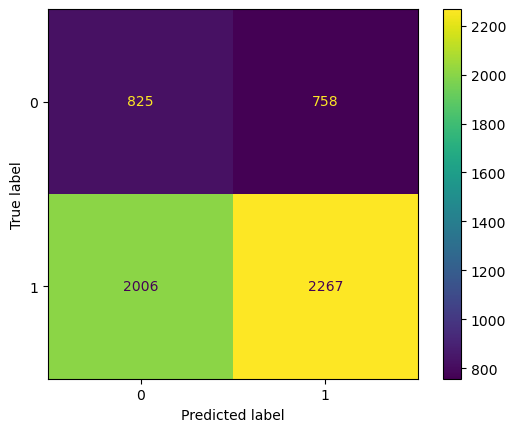

In [52]:
# Convert predictions into a form that sklearn will accept
yhat8 = finalizePredictions(elkanModel2)
categoryNames = reconstructLabels(yhat8, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhat8))
cm.plot()

# Compute accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat8))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs,
                                                                                      y_pred = yhat8, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs,
                                                                                y_pred = yhat8, average = "weighted"))

I start to suspect that we are categorizing something other than Pneumonia. The confusion matrices between the elkan and lloyd algorithms are essentially identical, which hints the likelihood that there are real categories that KMeans has discovered that are present in the chest X-Rays. My best guesses are patient size, shape, bone structure, race, etc. We would need to use these labels on a bunch of different labelled training data to figure out what the clusters represent. I suppose that's why we consider the point of Unsupervised Learning to find hidden trends that the data analyst didn't expect! That said, the models do have some predictive power over pneumonia, so whatever clusters are being discovered are at least correlated with pneumonia (or likeliness to develop pnuemonia). I would like to investigate this further by increasing pixDesired value which I kept low for computational reason. I would get back to this when the time allows.

## Comparison with supervised Learning Models

I'll use the training data (rows 0 through 5231) to try to predict the labels of the test data (the rest of the rows). It is fair to use the PCA transformed reduced-data, because the PCA did not know the labels of the data during transformation. As such the reducedData does not have any additional predictive power over the initial data, it just runs faster. In fact it will be on average worse, because we only account choose to account for 0.98 of the variance across all images. I will use a Random Forest for speed and accuracy.

#### 3 Categories

853.2331781387329
The Random Forest with 3 categories had accuracy: 0.5689102564102564
The Random Forest with 3 categories had weighted average precision: 0.7445121303816956
The Random Forest with 3 categories had weighted average recall: 0.5689102564102564


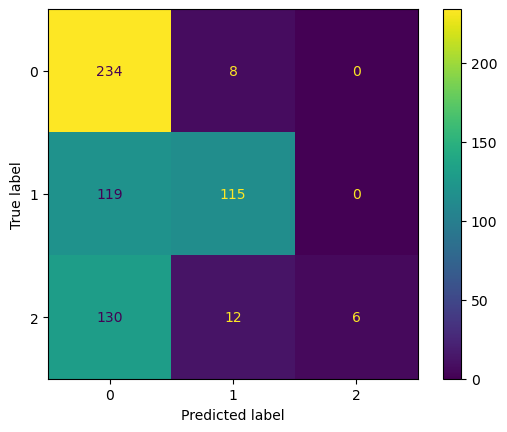

In [56]:
n_train = 5232
startTime = time.time()
forest = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs = 14).fit(reducedData[:5232, :], labs[:5232])
endTime = time.time()
print(endTime - startTime)
yhat9 = forest.predict(reducedData[5232: , :])

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = labs[5232: ], y_pred = yhat9))
cm.plot()

# Compute accuracy, precision, and recall
print("The Random Forest with 3 categories had accuracy:" , accuracy_score(y_true = labs[5232: ], y_pred = yhat9))
print("The Random Forest with 3 categories had weighted average precision:", 
      precision_score(y_true = labs[5232: ],y_pred = yhat9, average = "weighted"))
print("The Random Forest with 3 categories had weighted average recall:", 
      recall_score(y_true = labs[5232: ], y_pred = yhat9, average = "weighted"))

#### 2 Categories

535.7123534679413
The Random Forest with 3 categories had accuracy: 0.6746794871794872
The Random Forest with 3 categories had weighted average precision: 0.3226744186046512
The Random Forest with 3 categories had weighted average recall: 0.05929487179487179


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


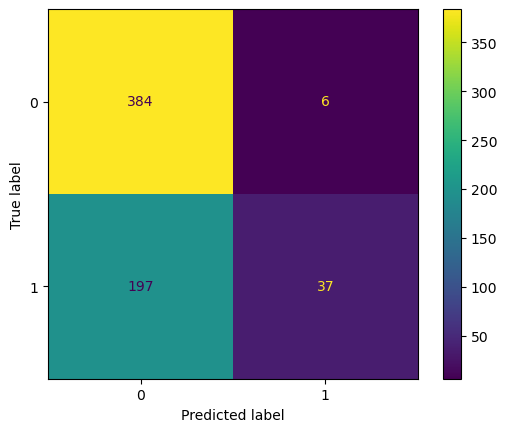

In [57]:
startTime = time.time()
forest = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs = 14).fit(reducedData[:5232, :], labs2[:5232])
endTime = time.time()
print(endTime - startTime)
yhat10 = forest.predict(reducedData[5232: , :])

cm = ConfusionMatrixDisplay(confusion_matrix(y_true = labs2[5232: ], y_pred = yhat10))
cm.plot()

# Compute accuracy, precision, and recall
print("The Random Forest with 3 categories had accuracy:" , accuracy_score(y_true = labs2[5232: ], y_pred = yhat10))
print("The Random Forest with 3 categories had weighted average precision:", 
      precision_score(y_true = labs[5232: ],y_pred = yhat10, average = "weighted"))
print("The Random Forest with 3 categories had weighted average recall:", 
      recall_score(y_true = labs[5232: ], y_pred = yhat10, average = "weighted"))

## Evaluation

By now it seems that the unsupervised models were seeing something it considered more prominent than infected vs. non infected lungs in the chest X-Rays. To determine whether the clusters are similar, let's compare them! I'll make a cosine-similarity matrix using sklearn, then map the domain of values to $[0,1]$ using the following formula:

$$ \text{sim}(\vec{y_1}, \vec{y_2}) = 0.5 + 0.5 * \text{Pearson}(\vec{y_1}, \vec{y_2})$$

In [58]:
# Correlation matrix to compare similarity over predictions for 3 category models
yhatAll3Categories = np.vstack((
    yhat1.reshape(1, yhat1.shape[0]),
    yhat3.reshape(1, yhat3.shape[0]),
    yhat5.reshape(1, yhat5.shape[0]),
    yhat7.reshape(1, yhat7.shape[0]))
)

cosineMatrix = cosine_similarity(yhatAll3Categories)
print(.5 + .5 * cosineMatrix)

[[1.         0.67694524 0.79319435 0.79319435]
 [0.67694524 1.         0.58626763 0.58626763]
 [0.79319435 0.58626763 1.         1.        ]
 [0.79319435 0.58626763 1.         1.        ]]


We would expect a similarity metric of $0.333$ if there was no correlation between any two clusters because there are three categories. The correlations are much higher than that; all models had something in common. As such we might think to bag the models and use the consensus opinion. Because models 5 and 7 had a perfect correlation (the K-Means models), we need to exlude one for the bagging to work. Let's try that and see how that affects accuracy:

In [59]:
# Take out perfectly correlated prediction yhat7
yhatMost3Categories = np.vstack((
    yhat1.reshape(1, yhat1.shape[0]),
    yhat3.reshape(1, yhat3.shape[0]),
    yhat5.reshape(1, yhat5.shape[0])
))

The Bagged Model with 3 categories had accuracy: 0.45235655737704916
The Bagged Model with 3 categories had weighted average precision: 0.4141863651240537
The Bagged Model with 3 categories had weighted average recall: 0.45235655737704916


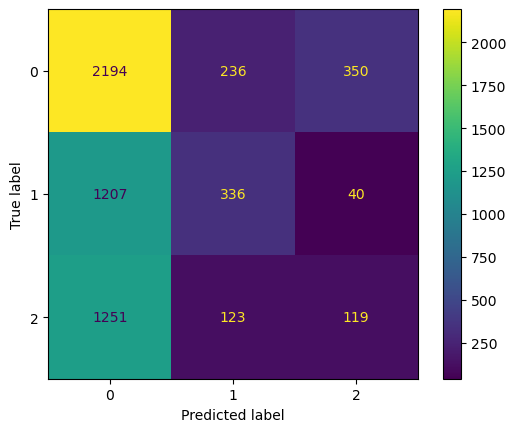

In [67]:
# Get Bagged Predictions
yhatBagged3 = majorityRule3(yhatMost3Categories)

# Convert Labels to a form sklearn will like
categoryNames = reconstructLabels(yhatBagged3, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

# Print confusion matrix
cm = ConfusionMatrixDisplay(confusion_matrix(y_true = newlabs, y_pred = yhatBagged3))
cm.plot()

# Compute accuracy, precision, and recall
print("The Bagged Model with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhatBagged3))
print("The Bagged Model with 3 categories had weighted average precision:", 
      precision_score(y_true = newlabs, y_pred = yhatBagged3, average = "weighted"))
print("The Bagged Model with 3 categories had weighted average recall:", 
      recall_score(y_true = newlabs, y_pred = yhatBagged3, average = "weighted"))

In the bagged model, the metrics went up a little bit compared to the L2-Loss NMF and the K-Means models, but were still worse than the KL-Loss NMF. It seems that the L2-Loss NMF and K-Means models saw some consistently different clusters in the data than pneumonia status, whereas KL-Loss NMF saw more pneumonia. As such the bagged model destructively interferes with itself, losing a little in metrics. 

It is worth noting that the supervised model (which is the gold standard in predicting labels) had a pretty poor performance too, even though I gave it a VERY long time to train. The L2-Loss NMF and K2-Loss NMF both beat the Random Forest for 2 Category classification in accuracy and recall! That said, they both performed quite a bit worse in precision. The bad performance of all models shows a couple truths: 
1. There is inherent difficulty in detecting pneumonia in X-Rays. 
2. 5000 images is not enough to teach a machine how to read a chest X-Ray for pneumonia. I'd like to repeat the project with an extra order of magnitude of data.

#### Here's my results summary for the 3 Category Models:

| 3 Categories  | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| L2-Loss NMF   | 0.4151   | 0.4667    | 0.4151 |
| KL-Loss NMF   | 0.4600   | 0.4847    | 0.4600 |
| Lloyd KMeans  | 0.4136   | 0.4136    | 0.4117 |
| Elkan KMeans  | 0.4117   | 0.4136    | 0.4117 |
| Bagged        | 0.4558   | 0.4170    | 0.4558 |
| Random Forest | 0.5689   | 0.7445    | 0.5689 |

#### Here's my results summary for the 2 Category Models:

| 2 Categories  | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| L2-Loss NMF   | 0.7170   | 0.6214    | 0.7170 |
| KL-Loss NMF   | 0.7222   | 0.5947    | 0.7222 |
| Lloyd KMeans  | 0.5280   | 0.6256    | 0.5280 |
| Elkan KMeans  | 0.5280   | 0.6256    | 0.5280 |
| Random Forest | 0.6746   | 0.7358    | 0.6747 |

## Discussion

A good way to try and improve the unsupervised models would be to isolate the lungs away from the rest of the body in the X-Rays before feeding the data into the models. I'm not sure how I would go about doing this; I might need yet another layer of supervised models that know lungs apart from the rest of the body. I think that would be a good master's thesis-level project.

In this project I practiced importing, cleaning, and reducing image data. I played with 8 unsupervised learning models, and built custom functions to reconstruct labels and try to figure out what the algorithms were seeing. The algorithms had consistent clusterings as is evidenced by the similarity matrix earlier in this section. I wonder what they were seeing if not pneumonia. Sex? Bone damage? Age groups? There are really any number of human comprehensible clustering options, and even more non-human comprehensible ones. There is no guarentee that the unsupervised models are going to do what you expect - I suppose that's the primary take away from this project. Unsupervised models are designed to find trends that a data analyst wouldn't. It is then the data analyst's job to figure out what the groupings are post-defacto. 

## Bibliography

1) [Data repository](https://data.mendeley.com/datasets/rscbjbr9sj/3)

2) [Past Research on Subject](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

3) Requested Citation: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

4) [Usage of cv2](https://www.geeksforgeeks.org/python-opencv-cv2-imshow-method/)

